=============================

Moist Adiabats on a Tephigram

=============================


Sept 2015

nmoisseeva@eos.ubc.ca


This notebook is intended to summarize the work on moist adiabats on a tephigram. 



In [2]:
#import necessary packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7  # that's default image size for this

Set up thermodynamical constants:

In [60]:
a = 0.285611 #Rd/Cp: for dry air
b = 1.35e7   #K^2: Lv^2*Eps/Cp*Rd
c = 2488.4   #K: Lv/Cp
LvRv = 5422. #K: Lv/Rv
T0 = 273.15  #0C


Eps = 0.622  #gv/gd: ratio of gas constants dry vs vapour
e0 = 0.611   #kPa: Clausius-Clayperon constant

Next, set up a test values for moist adiabat labels and pressure, and some storage arrays. Note that the range of pressures is defined from 100 to 1kP with 0.01 integration step, to ensure the potential temperature formula doesn't blow up for values less than 1. Also the tested temperature range is limited to +30C, as past this value the specific heat of air begins to change, which can introduce additional error into the equations. 

In [61]:
Prange = np.arange(100,1, -0.01)        
ThetaW = np.arange(-50,35)              
adiabats = np.empty((len(Prange),len(ThetaW)))
dry_adiabats = np.empty_like(adiabats)

Now, define formulas for Clausius-Clayperon, saturation mixing ratio and dP/dT as follows:

\begin{equation}
e_s = e_0 * exp(\frac{L_v}{R_v} * (\frac{1}{T_0}-\frac{1}{T}))
\end{equation}

\begin{equation}
r_s = \frac{\varepsilon * e_s}{P - e_s}
\end{equation}

\begin{equation}
\frac{\Delta T}{\Delta P} = \frac{a * T + c * r_s}{P * (1 + \frac{b * r_s}{T^2})}
\end{equation}


In [62]:
def f_es(T):
	return  e0*np.exp(LvRv*(1./T0 - 1./T))

def f_rs(P,es):
	return  Eps*es / (P - es)

def dTdP(P,T):
	return (a*T + c*rs)/(P*(1+(b*rs/T**2)))

Manually integrate to calculate moist adiabats (for each pressure and temperature):

In [65]:
for nT, Temp in enumerate(ThetaW):
	T = Temp + T0
	for nP,Pres in enumerate(Prange):
		es = f_es(T)
		rs = f_rs(Pres,es)
		grad = dTdP(Pres,T)
		T = T - grad*0.01
		adiabats[nP,nT] = T                       #store moist adiabat
		dry_adiabats[nP,nT] = T*((100./Pres)**a)  #store dry adiabat

Plot some adiabats (sanity check) every 10C:

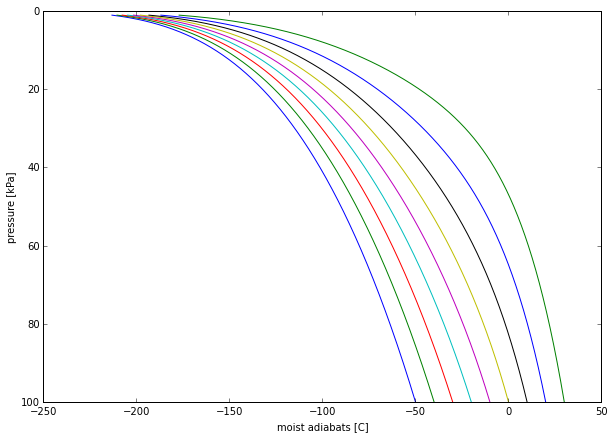

In [66]:
plt.plot(adiabats[:,0::10]-T0,Prange);
plt.gca().invert_yaxis();
plt.xlabel("moist adiabats [C]");
plt.ylabel("pressure [kPa]");

Define a function to calculate equivalent potential temperature:

\begin{equation}
    \theta_e = \theta_w * exp(\frac{a_3 * r_{s0}}{\theta_w})
\end{equation}

In [67]:
a3 = 2490.  #K*kg_air/kg_vapour
def f_thE(ThetaW,rs0):
	return ThetaW * np.exp(a3*rs0/ThetaW)

Note, that the value of $a_3$ will be discussed further below. 

Next, calculate equivalent temperature for each moist adiabat:

In [68]:
ThetaE = np.empty((len(ThetaW)))
for nT, Temp in enumerate(ThetaW):
	T = Temp + T0
	es0 = f_es(T)
	rs0 = f_rs(100,es0)
	ThetaE[nT] = f_thE(T,rs0)

Finally, we can create an array of normalized adiabats, by using the following expression:

\begin{equation}
\theta_{norm} = \frac{\theta - \theta_{dry}}{\theta_e}
\end{equation}

This should ensure that all adiabats start at 0 at the surface and approach -1 at the top of the atmosphere. Since we did not test the pressures close to the top of the atmosphere (we stopped at 1kPa) the end of the normalized adiabat should reach values of ~-0.8

In [69]:
norm_adiabats = (adiabats - dry_adiabats)/ThetaE

If successful, all adiabats should collapse into a single shape. 

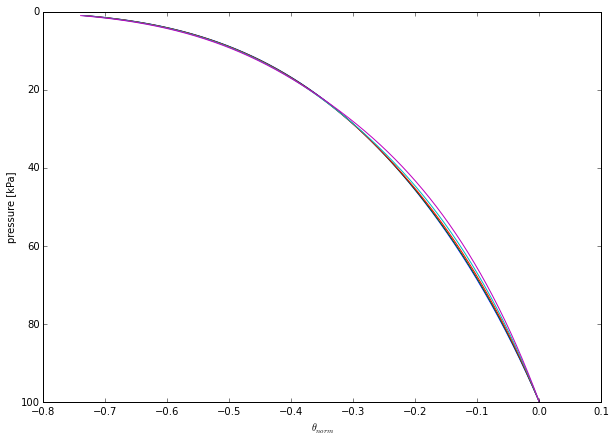

In [70]:
plt.plot(norm_adiabats[:,60::6], Prange);
plt.gca().invert_yaxis();
plt.ylabel("pressure [kPa]");
plt.xlabel(r"$\theta_{norm}$");

This appears to work reasonably well for the given range of temperatures and pressures. To evaluate the error we can calculate the standard deviation for each $\theta_{norm}$ value and plot the resultant curve:

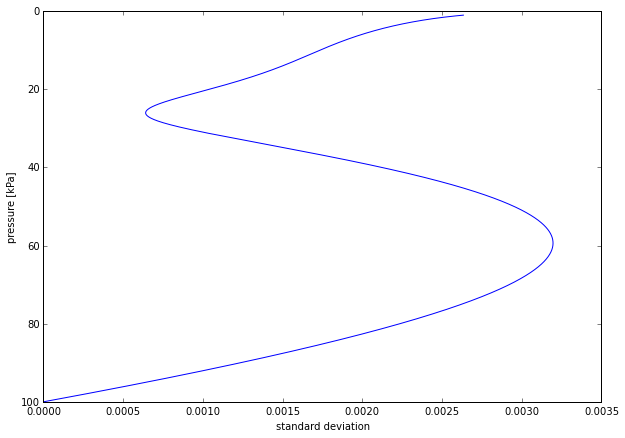

In [71]:
spread = np.std(norm_adiabats, axis = 1)
plt.plot(spread, Prange);
plt.gca().invert_yaxis();
plt.xlabel("standard deviation");
plt.ylabel("pressure [kPa]");

Note that the standard deviation values are generally small, remaining below 0.0045 (or relatively less than half a percent of $\theta_{norm}$. By varying the value of $a_3$ the distribution of error can be modified. For example, by setting $a_3 = 2300$ K kg air /kg vapour the relative maximum near 60 kPa drops to 0.003, while the value at the top of the atmosphere reaches 0.006. 

Moreover, simply reducing the tested temperature range to extend to the maximum of 25C reduces maximum standard deviation to 0.002. 

Generally, the remaining error is likely caused by the dependance of constants on temperature (i.e. they are not truly constants). The mid-range bulge in the normalized graph is driven by the contribution from the saturated mixing ration term. With larger moisture content at higher temperatures the error grows. 

To use the above relationship, $\theta_{norm}$ can be averaged to produce a single similarity relationship and fit with a simple exponential function. Based on $\theta_w$, the relationship between $\theta_{norm}$ and $P$, calculated values of $e_s$, $r_s$ and $\theta_{dry}$ can be used to determine the temperature. 

In [24]:
print np.shape(Prange)

(9900,)
